erklärung von warum zu text ändern, chunks, embedding und vektor datenbank

wir müssen pre processing machen, da praktisch alle json files, ausser das von wikipedia, als tabellen mit zahlen gespeichert sind. Die Inhalte für den Input Teil des RAG Systems müssen in Textform sein.
(z.B. json, pdf, csv) & am besten als Strings pro Chunk.
chunk = "Im Jahr 2022 hatte UBS ein Eigenkapital von 56,8 Mrd. USD und Schulden von 193 Mrd. USD."

das ist eben sehr wichtig für den schritt embeddings. embeddings sind vektor-repräsentationen eines textes, damit kann man ähnliche texte finden, auch wenn die wörter verschieden sind. Und man braucht sowieso alles in Textform, weil LLMs (wie ChatGPT) mit Text arbeiten, nicht mit Tabellen oder JSON direkt. LLMs verstehen nur Wörter und Sätze, nicht direkt Strukturen wie:
{"Eigenkapital": 5000000000}
mittlerweile können sich llms ein einfacheres bild machen und sagen datei titel ist ubs und gespeichert ist eigenkapital also kann man darauf schliessen dass eigenkapitel der ubs gemeint ist. 
beim rag wäre das aber sehr schwer umzusetzen und darum muss man alles so gut wie möglich in text haben um das dann in chunks zu speichern.

Wenn du fragst:

Wie hoch war das Eigenkapital von UBS 2022?
Der LLM braucht einen passenden Text-Abschnitt (Chunk), damit er die Antwort darin erkennt.
→ Rohdaten wie "Eigenkapital": 5000000000 sagen ihm nichts – er braucht Kontext in Sprache.

🔹 Chunk = ein sinnvoller Textabschnitt, typischerweise:
1–3 Sätze
oder ein Absatz
oder eine Aussage mit Bedeutung

❌ Kein Chunk:
"Eigenkapital"
"5000000000"
→ Das ist für das Modell zu wenig Kontext. Es weiß nicht: „Was ist 5 Mrd.? Für wen? Wann?“

✅ Besserer Chunk:
"Im Jahr 2022 betrug das Eigenkapital von UBS 5 Milliarden USD."
→ Das ist ein vollständiger, verständlicher „Textblock“, der in Embeddings übersetzt werden kann.

❓ 3. Was ist ein Embedding?

🧠 Embedding = ein Zahlen-Vektor, der die Bedeutung eines Textes beschreibt
Stell dir vor:

Ein Text wie „UBS hat 5 Mrd. Eigenkapital“ → wird in einen Vektor mit 768 Zahlen umgewandelt.
Das ist wie ein „Fingerabdruck der Bedeutung“ dieses Textes.
📦 Beispiel:
"Das Eigenkapital beträgt 5 Mrd." → [0.12, -0.88, 0.03, ..., 0.41]
"UBS hat ein Eigenkapital von 5 Milliarden." → sehr ähnlicher Vektor!
→ So kann ein System erkennen: „Ah, das bedeutet dasselbe!“

❓ 4. Was ist eine Vektor-Datenbank?

🧠 Eine Vektor-Datenbank speichert:
viele solcher Embeddings (= Vektoren)
verknüpft mit deinem Originaltext
📍 Beispiel:

Vektor (Embedding)	Text-Chunk
[0.12, -0.88, 0.03, ...]	"UBS hatte 2022 ein Eigenkapital..."
[-0.23, 0.15, -0.44, ...]	"JPMorgan meldete 2019 einen Gewinn..."
Wenn du eine Frage stellst, z. B.:

"Wie hoch war das Eigenkapital von UBS 2022?"
Dann wird die Frage auch in einen Vektor umgewandelt – und die Datenbank findet den ähnlichsten Chunk, der dazu passt.

✅ Kurz zusammengefasst


Konzept	Erklärung
Textform	GPT versteht nur Sprache, keine Zahlenlisten oder Tabellen direkt
Chunk	Ein sinnvoller Textabschnitt mit Kontext, z. B. 1–3 Sätze
Embedding	Zahlencode, der die Bedeutung eines Textes beschreibt (z. B. 768 Zahlen)
Vektor-Datenbank	Sucht nach dem „bedeutungsmäßig ähnlichsten“ Text


beispiel von pre processing:

Rohdaten:

{
  "index": "2024-12-31",
  "Total Assets": 1565028000000.0,
  "Cash And Cash Equivalents": 223329000000.0,
  "Total Debt": 322128000000.0,
  "Common Stock Equity": 85079000000.0
}
→ Wird zu:

Am 31. Dezember 2024 hatte UBS insgesamt 1,56 Billionen USD an Vermögenswerten. Die liquiden Mittel betrugen 223,33 Milliarden USD. Die gesamten Schulden beliefen sich auf 322,13 Milliarden USD. Das Eigenkapital der Aktionäre lag bei 85,08 Milliarden USD.



und allgemein wollte ich etwas neues versuchen. die meisten RAG System aufbau/experimente sind immer direkt mit text oder pdf mit text. ich sehe praktisch nie / sehr selten, dass solche daten genommen werden wie ich (also tabellen und zaheln scrapen) und diese dann in text chunks umzuwandeln, deshalb sah ich das als gute challenge einmal ein rag aufzubauen mit anderer art.

In [ ]:
# chunk generator für balance_sheet (pfad und bank muss jeweils angepasst werden)
# musste es so lösen, weil wenn ich alles alle banken und alle json files gibt es probleme, 
# weil Diese enthalten Fließtext oder komplex strukturierte Inhalte, die wir anders verarbeiten müssen als die tabellarischen Zeitreihen. 
# da alle typen anderst gemacht werden müssen werde ich ein skript pro file schreiben

# Das programmiert so wie hier jetzt unten ist der perfekte Ansatz, wenn du ganz sicherstellen willst, dass jede Dateiart korrekt verarbeitet wird – sauber, strukturiert, reproduzierbar 💯

import json
import os
import numpy as np

# SET YOUR FILE PATH HERE (manually one at a time)
FILE_PATH = "data/ubs/ubsg_balance_sheet.json"
BANK = "UBSG"
SOURCE = "balance_sheet"

# Define output path
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILENAME = f"{BANK.lower()}_{SOURCE}_chunks.jsonl"
OUTPUT_PATH = os.path.join(OUTPUT_FOLDER, OUTPUT_FILENAME)

# Fields to include in chunks
RELEVANT_FIELDS = {
    "Total Assets": "total assets",
    "Cash And Cash Equivalents": "cash and cash equivalents",
    "Total Debt": "total debt",
    "Common Stock Equity": "common stock equity",
    "Tangible Book Value": "tangible book value",
    "Net Debt": "net debt"
}

# Format helper
def format_number(value):
    if value is None or value != value or (isinstance(value, float) and np.isnan(value)):
        return "not available"
    if abs(value) >= 1_000_000_000_000:
        return f"{value / 1_000_000_000_000:.2f} trillion USD"
    elif abs(value) >= 1_000_000_000:
        return f"{value / 1_000_000_000:.2f} billion USD"
    elif abs(value) >= 1_000_000:
        return f"{value / 1_000_000:.2f} million USD"
    else:
        return f"{value:.0f} USD"

# Load JSON
with open(FILE_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

# Generate Chunks
chunks = []
for row in data:
    date = row.get("index") or "unknown"
    lines = [f"As of {date}, {BANK} reported:"]
    for key, label in RELEVANT_FIELDS.items():
        value = format_number(row.get(key))
        lines.append(f"- {label.capitalize()}: {value}")
    text = "\n".join(lines)

    chunks.append({
        "text": text,
        "metadata": {
            "bank": BANK,
            "date": date,
            "source": SOURCE
        }
    })

# Save to /data_chunks
with open(OUTPUT_PATH, "w", encoding="utf-8") as out_file:
    for chunk in chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(chunks)} chunks saved to:\n{OUTPUT_PATH}")


✅ 5 chunks saved to:
/Users/morenogallo/Library/Mobile Documents/com~apple~CloudDocs/Bachelorarbeit/Fact_Checking/data_chunks/ubsg_balance_sheet_chunks.jsonl


In [ ]:
# chunk generator für cashflow (pfad und bank muss jeweils angepasst werden)

import json
import os
import numpy as np

# SET YOUR FILE PATH HERE (manually one at a time)
FILE_PATH = "data/ubs/ubsg_cashflow.json"
BANK = "UBSG"
SOURCE = "cashflow"

# Define output path
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILENAME = f"{BANK.lower()}_{SOURCE}_chunks.jsonl"
OUTPUT_PATH = os.path.join(OUTPUT_FOLDER, OUTPUT_FILENAME)

# Cashflow-relevant fields
RELEVANT_FIELDS = {
    "Operating Cash Flow": "operating cash flow",
    "Investing Cash Flow": "investing cash flow",
    "Financing Cash Flow": "financing cash flow",
    "Free Cash Flow": "free cash flow",
    "Beginning Cash Position": "beginning cash position",
    "End Cash Position": "end cash position",
    "Changes In Cash": "change in total cash"
}

# Format helper
def format_number(value):
    if value is None or value != value or (isinstance(value, float) and np.isnan(value)):
        return "not available"
    if abs(value) >= 1_000_000_000_000:
        return f"{value / 1_000_000_000_000:.2f} trillion USD"
    elif abs(value) >= 1_000_000_000:
        return f"{value / 1_000_000_000:.2f} billion USD"
    elif abs(value) >= 1_000_000:
        return f"{value / 1_000_000:.2f} million USD"
    else:
        return f"{value:.0f} USD"

# Load JSON
with open(FILE_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

# Generate Chunks
chunks = []
for row in data:
    date = row.get("index") or "unknown"
    lines = [f"As of {date}, {BANK} cash flow report:"]
    for key, label in RELEVANT_FIELDS.items():
        value = format_number(row.get(key))
        lines.append(f"- {label.capitalize()}: {value}")
    text = "\n".join(lines)

    chunks.append({
        "text": text,
        "metadata": {
            "bank": BANK,
            "date": date,
            "source": SOURCE
        }
    })

# Save to /data_chunks
with open(OUTPUT_PATH, "w", encoding="utf-8") as out_file:
    for chunk in chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(chunks)} chunks saved to:\n{OUTPUT_PATH}")


✅ 4 chunks saved to:
/Users/morenogallo/Library/Mobile Documents/com~apple~CloudDocs/Bachelorarbeit/Fact_Checking/data_chunks/ubsg_cashflow_chunks.jsonl


In [ ]:
# chunk generator für earning_dates (pfad und bank muss jeweils angepasst werden)

import json
import os
import numpy as np

# Set your input path + bank name
FILE_PATH = "data/ubs/ubsg_earning_dates.json"
BANK = "UBSG"
SOURCE = "earning_dates"

# Define output folder + file name
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILENAME = f"{BANK.lower()}_{SOURCE}_chunks.jsonl"
OUTPUT_PATH = os.path.join(OUTPUT_FOLDER, OUTPUT_FILENAME)

# Format helper
def format_number(value, suffix="USD"):
    if value is None or value != value or (isinstance(value, float) and np.isnan(value)):
        return "not available"
    return f"{value:.2f} {suffix}"

# Load JSON
with open(FILE_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

# Generate Chunks
chunks = []
for row in data:
    date = row.get("Earnings Date", "unknown")
    estimate = format_number(row.get("EPS Estimate"), "USD")
    reported = format_number(row.get("Reported EPS"), "USD")
    surprise = format_number(row.get("Surprise(%)"), "%")

    text = (
        f"On {date}, {BANK} reported earnings per share (EPS) of {reported}, "
        f"compared to an estimate of {estimate}. "
        f"The surprise was {surprise}."
    )

    chunks.append({
        "text": text,
        "metadata": {
            "bank": BANK,
            "date": date,
            "source": SOURCE
        }
    })

# Save to /data_chunks
with open(OUTPUT_PATH, "w", encoding="utf-8") as out_file:
    for chunk in chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(chunks)} chunks saved to:\n{OUTPUT_PATH}")




✅ 12 chunks saved to:
/Users/morenogallo/Library/Mobile Documents/com~apple~CloudDocs/Bachelorarbeit/Fact_Checking/data_chunks/ubsg_earning_dates_chunks.jsonl


In [ ]:
# chunk generator für financials (pfad und bank muss jeweils angepasst werden)

import json
import os
import numpy as np

# Set your file path + bank info
FILE_PATH = "data/ubs/ubsg_financials.json"
BANK = "UBSG"
SOURCE = "financials"

# Define output location
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILENAME = f"{BANK.lower()}_{SOURCE}_chunks.jsonl"
OUTPUT_PATH = os.path.join(OUTPUT_FOLDER, OUTPUT_FILENAME)

# Format helper
def format_number(value):
    if value is None or value != value or (isinstance(value, float) and np.isnan(value)):
        return "not available"
    if abs(value) >= 1_000_000_000_000:
        return f"{value / 1_000_000_000_000:.2f} trillion USD"
    elif abs(value) >= 1_000_000_000:
        return f"{value / 1_000_000_000:.2f} billion USD"
    elif abs(value) >= 1_000_000:
        return f"{value / 1_000_000:.2f} million USD"
    else:
        return f"{value:.0f} USD"

# Load JSON
with open(FILE_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

# Generate chunks – all fields included
chunks = []
for row in data:
    date = row.get("index") or "unknown"
    lines = [f"As of {date}, {BANK} reported the following financials:"]

    for key, value in row.items():
        if key == "index":
            continue
        value_str = format_number(value)
        label = key.replace("_", " ").replace("  ", " ").capitalize()
        lines.append(f"- {label}: {value_str}")

    text = "\n".join(lines)

    chunks.append({
        "text": text,
        "metadata": {
            "bank": BANK,
            "date": date,
            "source": SOURCE
        }
    })

# Save as JSONL
with open(OUTPUT_PATH, "w", encoding="utf-8") as out_file:
    for chunk in chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(chunks)} financial chunks saved to:\n{OUTPUT_PATH}")


✅ 5 financial chunks saved to:
/Users/morenogallo/Library/Mobile Documents/com~apple~CloudDocs/Bachelorarbeit/Fact_Checking/data_chunks/ubsg_financials_chunks.jsonl


In [ ]:
# chunk generator für info (pfad und bank muss jeweils angepasst manuell werden)

# Du bekommst also standardmäßig YYYY-MM-DD, was optimal ist für:

# maschinelles Parsen
# Metadatenfilter
# internationale LLMs & Vektor-DBs

# ----------
# Ein Unix-Timestamp wie 851990400 bedeutet:

# Anzahl Sekunden seit dem 1. Januar 1970 um 00:00 UTC (Unix-Epoch)
# Das ist ein weltweit genormter Zeitstandard – unabhängig von Land oder Format.


import json
import os
import numpy as np
from datetime import datetime

# Set file + bank info
FILE_PATH = "data/ubs/ubsg_info.json"
BANK = "UBSG"
SOURCE = "info"

# Output path
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILENAME = f"{BANK.lower()}_{SOURCE}_chunks.jsonl"
OUTPUT_PATH = os.path.join(OUTPUT_FOLDER, OUTPUT_FILENAME)

# Format helpers
def format_number(value):
    if value is None or value != value or isinstance(value, (float, int)) and np.isnan(value):
        return "not available"
    if isinstance(value, (float, int)):
        if abs(value) >= 1_000_000_000_000:
            return f"{value / 1_000_000_000_000:.2f} trillion USD"
        elif abs(value) >= 1_000_000_000:
            return f"{value / 1_000_000_000:.2f} billion USD"
        elif abs(value) >= 1_000_000:
            return f"{value / 1_000_000:.2f} million USD"
        else:
            return f"{value:.0f} USD"
    return str(value)

def format_date(value):
    try:
        return datetime.utcfromtimestamp(int(value)).strftime('%Y-%m-%d')
    except:
        return str(value)

# Load JSON
with open(FILE_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

# Build fields from flat content
flat_fields = []
for key, value in data.items():
    if isinstance(value, (dict, list)):
        continue

    # Check for date fields
    if "date" in key.lower() and isinstance(value, (int, float)):
        value_str = format_date(value)
    else:
        value_str = format_number(value)

    label = key.replace("_", " ").replace("  ", " ").capitalize()
    flat_fields.append(f"{label}: {value_str}")

# Add long summary at the beginning
long_summary = data.get("longBusinessSummary", None)
if long_summary:
    flat_fields.insert(0, long_summary)
    flat_fields.insert(1, "\n--\n")

# Add officer data
officer_lines = []
if "companyOfficers" in data and isinstance(data["companyOfficers"], list):
    for officer in data["companyOfficers"]:
        if "name" in officer:
            name = officer["name"]
            title = officer.get("title", "unknown title")
            pay = format_number(officer.get("totalPay", "N/A"))
            officer_lines.append(f"{name}, {title} – Total Pay: {pay}")

if officer_lines:
    flat_fields.append("\nTop Executives:")
    flat_fields.extend(officer_lines)

# Final chunk text
text = "\n".join(flat_fields)

chunk = {
    "text": text,
    "metadata": {
        "bank": BANK,
        "date": "n/a",
        "source": SOURCE
    }
}

# Save
with open(OUTPUT_PATH, "w", encoding="utf-8") as out_file:
    json.dump(chunk, out_file, ensure_ascii=False)
    out_file.write("\n")

print(f"✅ Info chunk saved to:\n{OUTPUT_PATH}")



✅ Info chunk saved to:
/Users/morenogallo/Library/Mobile Documents/com~apple~CloudDocs/Bachelorarbeit/Fact_Checking/data_chunks/ubsg_info_chunks.jsonl


/var/folders/jb/lln_4j7d4976cj9dpf8gkcsh0000gn/T/ipykernel_3234/603042743.py:49: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  return datetime.utcfromtimestamp(int(value)).strftime('%Y-%m-%d')


In [ ]:
# chunk generator für insider_transactions (pfad und bank muss jeweils manuell angepasst werden)

import json
import os
import pandas as pd
from datetime import datetime

# Datei-Pfade anpassen
FILE_PATH = "data/jpm/jpm_insider_transactions.json"
BANK = "JPM"
SOURCE = "insider_transactions"
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILE = os.path.join(OUTPUT_FOLDER, f"{BANK.lower()}_{SOURCE}_chunks.jsonl")

# Lade JSON als DataFrame
with open(FILE_PATH, "r", encoding="utf-8") as f:
    records = json.load(f)
df = pd.DataFrame(records)

# NaNs ersetzen durch "not available"
df = df.fillna("not available")

# Generiere Chunks
chunks = []
for _, row in df.iterrows():
    date_str = row["Start Date"]
    text_lines = []
    for col, val in row.items():
        if col != "index" and col != "Start Date":
            label = col.replace("_", " ").replace("  ", " ").capitalize()
            text_lines.append(f"{label}: {val}")
    chunk_text = "\n".join(text_lines)

    chunk = {
        "text": chunk_text,
        "metadata": {
            "bank": BANK,
            "date": date_str,
            "source": SOURCE
        }
    }
    chunks.append(chunk)

# Speichern
with open(OUTPUT_FILE, "w", encoding="utf-8") as out_file:
    for chunk in chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(chunks)} insider transaction chunks saved to:\n{OUTPUT_FILE}")




✅ 150 insider transaction chunks saved to:
/Users/morenogallo/Library/Mobile Documents/com~apple~CloudDocs/Bachelorarbeit/Fact_Checking/data_chunks/jpm_insider_transactions_chunks.jsonl


In [ ]:
# chunk generator für institutional_holders (pfad und bank muss jeweils manuell angepasst werden)

import json
import os
import pandas as pd

# File setup
FILE_PATH = "data/ubs/ubsg_institutional_holders.json"
BANK = "UBSG"
SOURCE = "institutional_holders"
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILE = os.path.join(OUTPUT_FOLDER, f"{BANK.lower()}_{SOURCE}_chunks.jsonl")

# Load as DataFrame
with open(FILE_PATH, "r", encoding="utf-8") as f:
    records = json.load(f)
df = pd.DataFrame(records)
df = df.fillna("not available")

# Build chunks
chunks = []
for _, row in df.iterrows():
    date_str = row["Date Reported"]
    lines = []
    for col, val in row.items():
        if col in ["index", "Date Reported"]:
            continue
        label = col.replace("_", " ").replace("  ", " ").capitalize()
        lines.append(f"{label}: {val}")
    text = "\n".join(lines)

    chunk = {
        "text": text,
        "metadata": {
            "bank": BANK,
            "date": date_str,
            "source": SOURCE
        }
    }
    chunks.append(chunk)

# Save as JSONL
with open(OUTPUT_FILE, "w", encoding="utf-8") as out_file:
    for chunk in chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(chunks)} institutional holder chunks saved to:\n{OUTPUT_FILE}")


✅ 10 institutional holder chunks saved to:
/Users/morenogallo/Library/Mobile Documents/com~apple~CloudDocs/Bachelorarbeit/Fact_Checking/data_chunks/ubsg_institutional_holders_chunks.jsonl


In [ ]:
# chunk generator für mutualfund_holders (pfad und bank muss jeweils manuell angepasst werden)

import json
import os
import pandas as pd

# File paths & info
FILE_PATH = "data/ubs/ubsg_mutualfund_holders.json"
BANK = "UBSG"
SOURCE = "mutualfund_holders"
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILE = os.path.join(OUTPUT_FOLDER, f"{BANK.lower()}_{SOURCE}_chunks.jsonl")

# Load data
with open(FILE_PATH, "r", encoding="utf-8") as f:
    records = json.load(f)
df = pd.DataFrame(records)
df = df.fillna("not available")

# Generate Chunks
chunks = []
for _, row in df.iterrows():
    date_str = row["Date Reported"]
    lines = []
    for col, val in row.items():
        if col in ["index", "Date Reported"]:
            continue
        label = col.replace("_", " ").replace("  ", " ").capitalize()
        lines.append(f"{label}: {val}")
    text = "\n".join(lines)

    chunks.append({
        "text": text,
        "metadata": {
            "bank": BANK,
            "date": date_str,
            "source": SOURCE
        }
    })

# Save as .jsonl
with open(OUTPUT_FILE, "w", encoding="utf-8") as out_file:
    for chunk in chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(chunks)} mutual fund holder chunks saved to:\n{OUTPUT_FILE}")


✅ 10 mutual fund holder chunks saved to:
/Users/morenogallo/Library/Mobile Documents/com~apple~CloudDocs/Bachelorarbeit/Fact_Checking/data_chunks/ubsg_mutualfund_holders_chunks.jsonl


In [ ]:
# chunk generator für news (pfad und bank muss jeweils manuell angepasst werden)

import json
import os
from datetime import datetime

# Input & Output Setup
FILE_PATH = "data/jpm/jpm_news.json"
BANK = "JPM"
SOURCE = "news"
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILE = os.path.join(OUTPUT_FOLDER, f"{BANK.lower()}_{SOURCE}_chunks.jsonl")

# Load JSON
with open(FILE_PATH, "r", encoding="utf-8") as f:
    records = json.load(f)

# Generate Chunks
chunks = []
for item in records:
    content = item.get("content", {})
    pub_date = content.get("pubDate", "unknown")
    title = content.get("title", "").strip()
    summary = content.get("summary", "").strip()
    thumbnail_url = content.get("thumbnail", {}).get("originalUrl", "")

    # Textchunk zusammenbauen
    text_parts = [
        f"Title: {title}" if title else "",
        f"Summary: {summary}" if summary else "",
        f"URL: {thumbnail_url}" if thumbnail_url else ""
    ]
    chunk_text = "\n".join([part for part in text_parts if part])

    if chunk_text:  # Nur speichern wenn sinnvoller Inhalt vorhanden
        chunk = {
            "text": chunk_text,
            "metadata": {
                "bank": BANK,
                "date": pub_date[:10],  # Nur YYYY-MM-DD
                "source": SOURCE
            }
        }
        chunks.append(chunk)

# Save to .jsonl
with open(OUTPUT_FILE, "w", encoding="utf-8") as out_file:
    for chunk in chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(chunks)} news chunks saved to:\n{OUTPUT_FILE}")


✅ 10 news chunks saved to:
data_chunks/jpm_news_chunks.jsonl


In [ ]:
# chunk generator für shareprices (pfad und bank muss jeweils manuell angepasst werden)

import json
import os
from datetime import datetime

# 🔧 Pfade anpassen
FILE_PATH = "data/ubs/ubsg_shareprices.json"
BANK = "UBSG"
SOURCE = "shareprices"
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILE = os.path.join(OUTPUT_FOLDER, f"{BANK.lower()}_{SOURCE}_chunks.jsonl")

# JSON laden
with open(FILE_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

chunks = []

for row in data:
    # Keys reparieren, falls Tuple-Strings wie "('BAC', 'Open')"
    fixed_row = {}
    for k, v in row.items():
        if isinstance(k, str):
            key_str = k
        elif isinstance(k, (list, tuple)):
            key_str = "_".join(str(part) for part in k)
        else:
            key_str = str(k)
        fixed_row[key_str] = v

    # Datum extrahieren – versuche alle Varianten
    possible_date_keys = [k for k in fixed_row.keys() if "date" in k.lower()]
    date = "unknown"
    for dk in possible_date_keys:
        date_candidate = fixed_row.get(dk)
        if isinstance(date_candidate, str) and len(date_candidate) >= 10:
            date = date_candidate[:10]
            break

    # Text zusammenbauen
    lines = [f"Date: {date}"]
    for key, value in fixed_row.items():
        if key.lower() not in [dk.lower() for dk in possible_date_keys]:
            lines.append(f"{key}: {value}")
    text = "\n".join(lines)

    chunks.append({
        "text": text,
        "metadata": {
            "bank": BANK,
            "date": date,
            "source": SOURCE
        }
    })

# Speichern
with open(OUTPUT_FILE, "w", encoding="utf-8") as out_file:
    for chunk in chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(chunks)} share price chunks saved to:\n{OUTPUT_FILE}")


✅ 7576 share price chunks saved to:
data_chunks/ubsg_shareprices_chunks.jsonl


In [ ]:
# chunk generator für wikipedia (pfad und bank muss jeweils manuell angepasst werden)

# warum man split_text() braucht:
# In vielen RAG-Systemen ist es üblich, lange Texte in kleinere Einheiten ("Chunks") zu teilen, z. B.:

# bessere Vektoreinbettung (Embeddings sind oft auf ~500–1000 Token beschränkt)
# präzisere Antworten auf Teilfragen
# niedrigere Kontextlängenbelastung bei LLM-Anfragen

import os
import json
from datetime import datetime

# 🔧 Wikipedia JSON-File & Infos
FILE_PATH = "data/ubs/ubsg_wikipedia.json"
BANK = "UBSG"
SOURCE = "wikipedia"
OUTPUT_FOLDER = "data_chunks"
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
OUTPUT_FILE = os.path.join(OUTPUT_FOLDER, f"{BANK.lower()}_{SOURCE}_chunks.jsonl")

# JSON laden
with open(FILE_PATH, "r", encoding="utf-8") as f:
    data = json.load(f)

# Datum formatieren
def parse_iso_date(iso_str):
    try:
        return datetime.fromisoformat(iso_str).strftime("%Y-%m-%d")
    except Exception:
        return "unknown"

date = parse_iso_date(data.get("last_updated", ""))
title = data.get("title", "Unknown")
url = data.get("url", "Unknown")
extract = data.get("extract", "").strip()

# Wikipedia-Text chunken (z. B. alle 1000 Wörter als eigener Chunk)
def split_text(text, max_words=200):
    words = text.split()
    chunks = []
    for i in range(0, len(words), max_words):
        chunk_text = " ".join(words[i:i + max_words])
        chunks.append(chunk_text)
    return chunks

text_chunks = split_text(extract)

# RAG-kompatible JSONL-Chunks
output_chunks = []
for i, chunk in enumerate(text_chunks):
    output_chunks.append({
        "text": f"{title} (Wikipedia excerpt {i+1})\n\n{chunk}",
        "metadata": {
            "bank": BANK,
            "date": date,
            "source": SOURCE,
            "title": title,
            "url": url,
            "chunk_id": i + 1
        }
    })

# Speichern
with open(OUTPUT_FILE, "w", encoding="utf-8") as out_file:
    for chunk in output_chunks:
        json.dump(chunk, out_file, ensure_ascii=False)
        out_file.write("\n")

print(f"✅ {len(output_chunks)} Wikipedia chunks saved to:\n{OUTPUT_FILE}")


✅ 53 Wikipedia chunks saved to:
/Users/morenogallo/Library/Mobile Documents/com~apple~CloudDocs/Bachelorarbeit/Fact_Checking/data_chunks/ubsg_wikipedia_chunks.jsonl


warum arbeite ich mit text und metadaten? und warum füge ich den bank namen nicht direkt in den text rein?

standardmässig sucht ein rag system nur im text feld. aber man sollte auch metadata in den suchraum enbeziehen. 


🔍 Warum trennen wir text und metadata?

text	metadata
für Embedding + Retrieval	für Filter, Kontext, Ranking, Logging
wird in die Vektor-Datenbank gechunkt	bleibt außerhalb (z. B. als Metadaten in FAISS, Chroma etc.)
wird direkt dem LLM gezeigt	kann für zusätzliche Steuerung verwendet werden

🤖 Wenn du dann fragst:

"Who is the biggest institutional holder of the bank BAC?"
Dann funktioniert das Retrieval nur korrekt, wenn du entweder:

✅ Option A: Den Banknamen auch im text erwähnst
(z. B. beim Chunkbau automatisch "For BAC: Holder: ...")

ODER

✅ Option B: Du nutzt metadata als Filterkriterium im RAG-Retriever!
Zum Beispiel mit LangChain + Chroma oder FAISS

wenn man das rag system aufbaut mit der kombination von text und metadata filter, dann hat man maximale robustheit sowie ist das auch optimal für ein sauberes RAG System, weil metadata bank name als zusätzlichen filter fungiert für die suche.

# EDA für Klarheit über die Chunk json files

In [25]:
# Imports and load all chunks

import os
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

CHUNKS_DIR = "data_chunks"

# load all Chunks from .jsonl-files
all_chunks = []

for file in os.listdir(CHUNKS_DIR):
    if file.endswith(".jsonl"):
        with open(os.path.join(CHUNKS_DIR, file), "r", encoding="utf-8") as f:
            for line in f:
                try:
                    chunk = json.loads(line)
                    all_chunks.append(chunk)
                except Exception as e:
                    print(f"Error in {file}: {e}")

print(f"✅ {len(all_chunks)} chunks loaded")


✅ 62984 chunks loaded


In [26]:
# find chunks without date or source

df_missing = pd.DataFrame([
    {
        "Bank": c["metadata"].get("bank", "unknown"),
        "Date": c["metadata"].get("date", "unknown"),
        "Source": c["metadata"].get("source", "unknown"),
        "Text Snippet": c["text"][:80] + "..."
    }
    for c in all_chunks
    if c["metadata"].get("date") in ["unknown", "n/a"] or not c["metadata"].get("source")
])

print(f"{len(df_missing)} Chunks have missing metadata.")
display(df_missing)


6 Chunks have missing metadata.


,Bank,Date,Source,Text Snippet
0,UBSG,n/a,info,UBS Group AG provides financial advice and sol...
1,BAC,n/a,info,"Bank of America Corporation, through its subsi..."
2,BNP,n/a,info,BNP Paribas SA provides various banking and fi...
3,HSBC,n/a,info,HSBC Holdings plc engages in the provision of ...
4,JPM,n/a,info,JPMorgan Chase & Co. operates as a financial s...
5,Citi,n/a,info,"Citigroup Inc., a diversified financial servic..."


bei info.json ist es nicht schlimm, dass es kein Datum hat, es handelt sich bei dieser Datei um allgemeine informationen der Banken, wie z.B. in welchen Bereichen sie aktiv sind oder was sie anbieten. das ist ja meistens zeit unabhängig.

In [27]:
# Chunks pro Bank

bank_counts = Counter(chunk["metadata"]["bank"] for chunk in all_chunks)
df_banks = pd.DataFrame(bank_counts.items(), columns=["Bank", "Chunk Count"])
df_banks = df_banks.sort_values(by="Chunk Count", ascending=False)
display(df_banks)


,Bank,Chunk Count
3,BAC,13412
4,Citi,12416
1,JPM,11621
5,HSBC,9673
2,BNP,8186
0,UBSG,7676


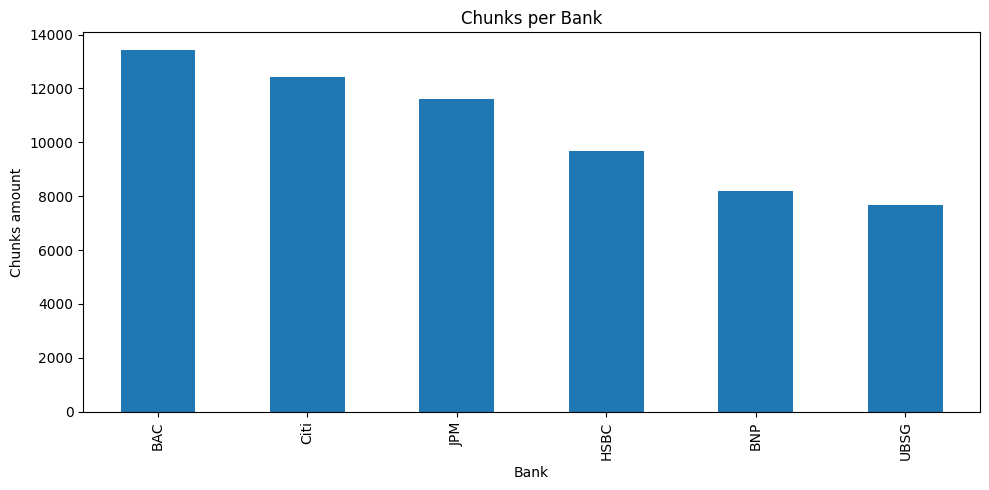

In [28]:
# Chunks pro Bank visual

df_banks.set_index("Bank").plot(kind="bar", figsize=(10,5), legend=False)
plt.title("Chunks per Bank")
plt.ylabel("Chunks amount")
plt.xlabel("Bank")
plt.grid(False)
plt.tight_layout()
plt.show()


In [30]:
# How many chunks per source?

source_counts = Counter(chunk["metadata"]["source"] for chunk in all_chunks)
df_sources = pd.DataFrame(source_counts.items(), columns=["Source", "Chunk Count"])
df_sources = df_sources.sort_values(by="Chunk Count", ascending=False)
display(df_sources)


,Source,Chunk Count
8,shareprices,61821
9,insider_transactions,591
3,wikipedia,261
2,earning_dates,72
4,mutualfund_holders,60
1,institutional_holders,45
10,news,40
5,financials,30
6,balance_sheet,30
0,cashflow,28


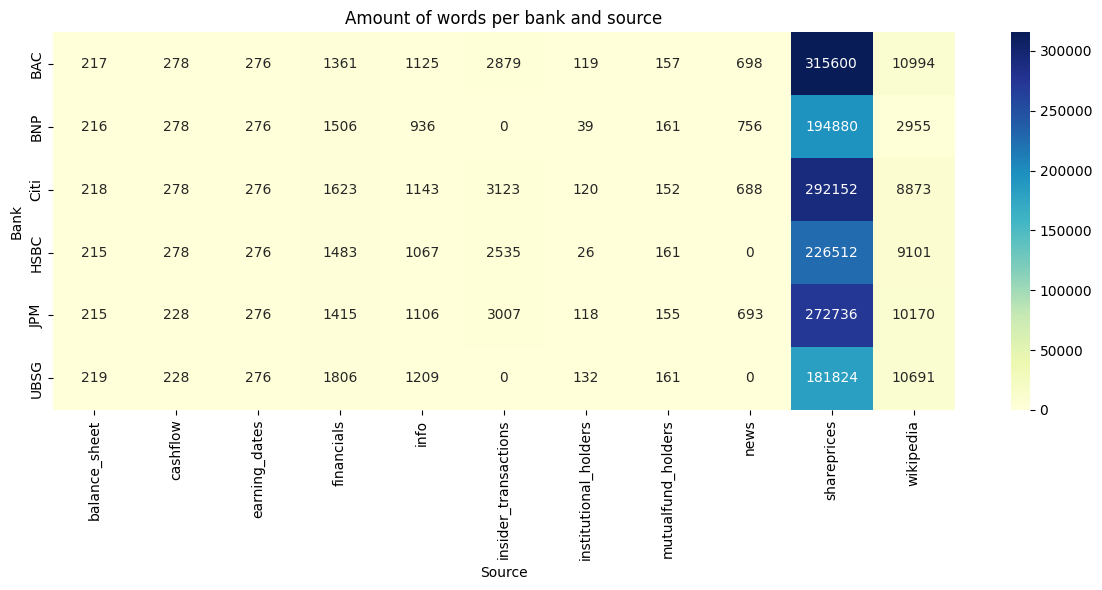

In [31]:
# Words pro bank and source heatmap

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# list with bank, source and text length
chunk_lengths = []

for chunk in all_chunks:
    bank = chunk["metadata"]["bank"]
    source = chunk["metadata"]["source"]
    length = len(chunk["text"].split())
    chunk_lengths.append({
        "Bank": bank,
        "Source": source,
        "Length": length
    })

df_lengths = pd.DataFrame(chunk_lengths)

# Pivot-Table: length per bank and source
pivot_len = df_lengths.pivot_table(
    index="Bank",
    columns="Source",
    values="Length",
    aggfunc="sum",
    fill_value=0
)

# Plot Heatmap
plt.figure(figsize=(12,6))
sns.heatmap(pivot_len, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Amount of words per bank and source")
plt.xlabel("Source")
plt.ylabel("Bank")
plt.tight_layout()
plt.show()



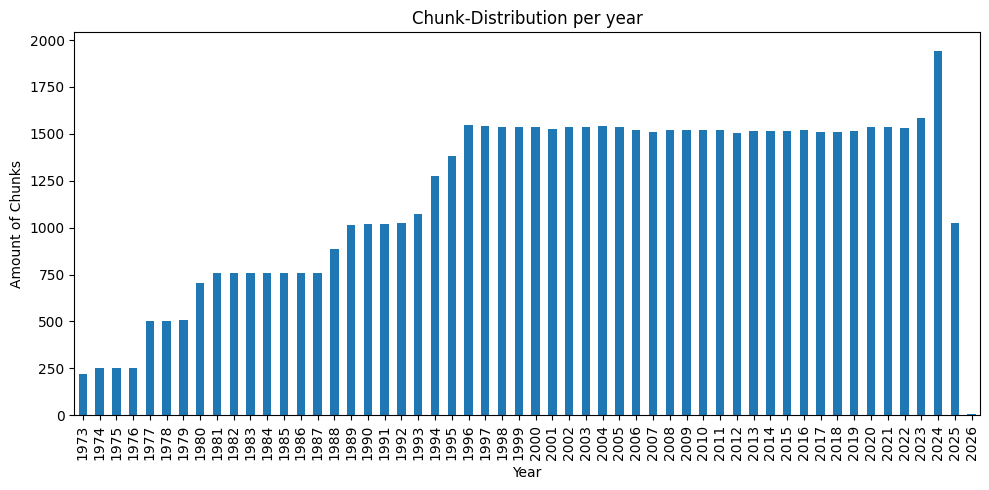

In [32]:
# Distribution of chunks over the years

years = []

for chunk in all_chunks:
    date = chunk["metadata"].get("date", "")
    if date != "n/a" and date != "unknown":
        year = date[:4]
        if year.isdigit():
            years.append(int(year))

year_counts = pd.Series(years).value_counts().sort_index()
year_counts.plot(kind="bar", figsize=(10,5))
plt.title("Chunk-Distribution per year")
plt.xlabel("Year")
plt.ylabel("Amount of Chunks")
plt.grid(False)
plt.tight_layout()
plt.show()


In [33]:
# How many unique years per bank are covered?

bank_years = {}

for chunk in all_chunks:
    bank = chunk["metadata"]["bank"]
    date = chunk["metadata"].get("date", "")
    if date not in ["n/a", "unknown"]:
        year = date[:4]
        bank_years.setdefault(bank, set()).add(year)

# DataFrame
df_year_coverage = pd.DataFrame([
    {"Bank": bank, "Unique Years": len(years)}
    for bank, years in bank_years.items()
]).sort_values(by="Unique Years", ascending=False)

display(df_year_coverage)


,Bank,Unique Years
3,BAC,54
4,Citi,50
1,JPM,47
5,HSBC,39
2,BNP,33
0,UBSG,32


In [34]:
# Preview of some chunks (Text and Metadata)

pd.DataFrame([
    {
        "Bank": c["metadata"]["bank"],
        "Date": c["metadata"]["date"],
        "Source": c["metadata"]["source"],
        "Text Snippet": c["text"][:100] + "..."
    }
    for c in all_chunks[:5]
])


,Bank,Date,Source,Text Snippet
0,UBSG,2023-12-31,cashflow,"As of 2023-12-31, UBSG cash flow report:\n- Op..."
1,UBSG,2022-12-31,cashflow,"As of 2022-12-31, UBSG cash flow report:\n- Op..."
2,UBSG,2021-12-31,cashflow,"As of 2021-12-31, UBSG cash flow report:\n- Op..."
3,UBSG,2020-12-31,cashflow,"As of 2020-12-31, UBSG cash flow report:\n- Op..."
4,JPM,2024-12-31,institutional_holders,Holder: Vanguard Group Inc\nPctheld: 0.0979\nS...


,Bank,Avg Chunk Word Count
0,UBSG,25.605263
5,HSBC,24.982322
1,JPM,24.965063
3,BAC,24.881002
4,Citi,24.858731
2,BNP,24.676643


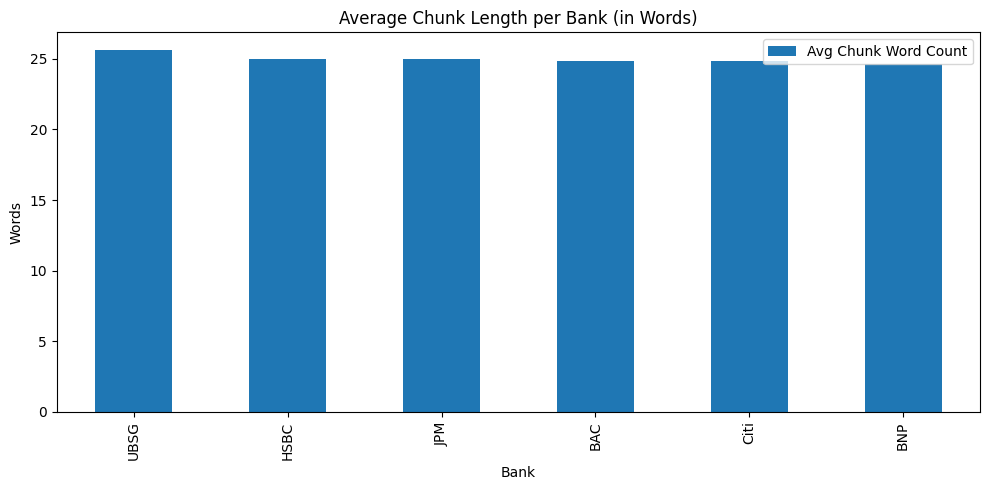

In [35]:
# Average length of texts per bank

import numpy as np

bank_lengths = {}

for chunk in all_chunks:
    bank = chunk["metadata"]["bank"]
    text_len = len(chunk["text"].split())
    bank_lengths.setdefault(bank, []).append(text_len)

# Calculate average text length
avg_lengths = {bank: np.mean(lengths) for bank, lengths in bank_lengths.items()}
df_avg_len = pd.DataFrame(avg_lengths.items(), columns=["Bank", "Avg Chunk Word Count"]).sort_values(by="Avg Chunk Word Count", ascending=False)
display(df_avg_len)

# 📈 Optional plot
df_avg_len.set_index("Bank").plot(kind="bar", figsize=(10,5))
plt.title("Average Chunk Length per Bank (in Words)")
plt.ylabel("Words")
plt.grid(False)
plt.tight_layout()
plt.show()


Average chunk length: 25.0 Words
Max: 1209 | Min: 11


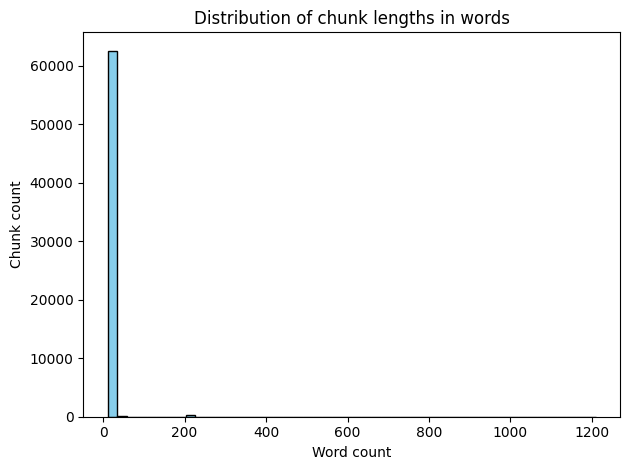

In [36]:
# Distribution of text lengths of all chunks

import numpy as np

lengths = [len(c["text"].split()) for c in all_chunks]

print(f"Average chunk length: {np.mean(lengths):.1f} Words")
print(f"Max: {np.max(lengths)} | Min: {np.min(lengths)}")

plt.hist(lengths, bins=50, color="skyblue", edgecolor="black")
plt.title("Distribution of chunk lengths in words")
plt.xlabel("Word count")
plt.ylabel("Chunk count")
plt.grid(False)
plt.tight_layout()
plt.show()

